<font color='blue'>**Load the data**</font>

In [2]:
import io
import os
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import pdb
from tqdm import tqdm
import datetime
import nltk.translate.bleu_score as bleu
import matplotlib.pyplot as plt
import gc

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
with open('rus-eng/rus.txt', 'r', encoding="utf8") as f:
    eng=[]
    rus=[]
    for i in f.readlines():
        splited_string = i.split("\t")
        eng.append(splited_string[0])
        rus.append(splited_string[1])
data = pd.DataFrame(data=zip(eng, rus), columns=['english','russian'])
print(data.shape)
del eng,rus
gc.collect()
data.head()

(421765, 2)


,english,russian
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!


<font color='blue'>**Preprocess data**</font>

In [5]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_rus(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    text = text.lower()
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['russian'] = data['russian'].apply(preprocess_rus)
data.head()

,english,russian
0,go,марш
1,go,иди
2,go,идите
3,hi,здравствуйте
4,hi,привет


In [6]:
rus_lengths = data['russian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

16.0


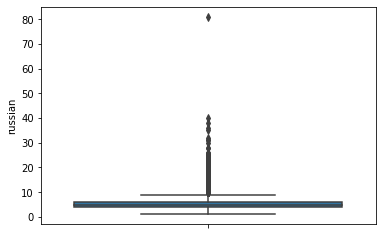

In [7]:
sns.boxplot(rus_lengths,orient='v')
print(np.percentile(rus_lengths,99.9))

In [8]:
#99.9 percentile value of input leght is 22 so we will will input lenght for seuquence to 20
encoder_inputs_length = 16
decoder_inputs_length = 16

In [9]:
data['russian_len'] = data['russian'].str.split().apply(len)
data = data[data['russian_len'] < encoder_inputs_length]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < encoder_inputs_length]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','russian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,russian,english_inp,english_out
0,марш,<start> go,go <end>
1,иди,<start> go,go <end>
2,идите,<start> go,go <end>
3,здравствуйте,<start> hi,hi <end>
4,привет,<start> hi,hi <end>


In [10]:
train, validation = train_test_split(data, test_size=0.1)
print(train.shape, validation.shape)

(378036, 3) (42004, 3)


In [11]:
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [12]:
tokenizer_rus = Tokenizer()
tokenizer_rus.fit_on_texts(data['russian'].values)

tokenizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_eng.fit_on_texts(data['english_inp'].values)

tokenizer_eng_out = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_eng_out.fit_on_texts(data['english_out'].values)

vocab_size_eng=len(tokenizer_eng.word_index.keys())
print(vocab_size_eng)

vocab_size_eng_out=len(tokenizer_eng_out.word_index.keys())
print(vocab_size_eng_out)

vocab_size_rus=len(tokenizer_rus.word_index.keys())
print(vocab_size_rus)


16635
16635
54706


In [13]:
class Dataset:
    def __init__(self, data, tokenizer_rus, tokenizer_eng,tokenizer_eng_out, max_len):
        self.encoder_inps = data['russian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tokenizer_eng = tokenizer_eng
        self.tokenizer_rus = tokenizer_rus
        self.tokenizer_eng_out = tokenizer_eng_out
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_rus.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenizer_eng.texts_to_sequences([self.decoder_inps[i]])
   
                
        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')

        
        self.decoder_target_data = self.tokenizer_eng_out.texts_to_sequences([self.decoder_outs[i]])
        self.decoder_target_data = pad_sequences(self.decoder_target_data, maxlen=self.max_len, dtype='int32', padding='post')
        
        return tf.convert_to_tensor(self.encoder_seq), tf.convert_to_tensor(self.decoder_inp_seq), tf.convert_to_tensor(self.decoder_target_data)

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [14]:
# encoder_inputs_length
# decoder_inputs_length
batch_size = 400
train_dataset = Dataset(train, tokenizer_rus, tokenizer_eng,tokenizer_eng_out, encoder_inputs_length)
test_dataset  = Dataset(validation, tokenizer_rus, tokenizer_eng,tokenizer_eng_out, encoder_inputs_length)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)


print(test_dataloader[0][1].shape)

(400, 16)


### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [15]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_units = lstm_size
        self.input_length = input_length
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence,states):
        
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return tf.convert_to_tensor(np.zeros((batch_size,self.lstm_units)))


<font color='blue'>**Attention**</font>

In [16]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):

    super().__init__()
    # Please go through the reference notebook and research paper to complete the scoring functions
    self.scoring_function = scoring_function
    self.V = Dense(1)
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.Wa = Dense(att_units)
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.W1 = Dense(att_units)
      self.W2 = Dense(att_units)
      
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    attention_weights = []
    context_vector = []
#     print(decoder_hidden_state.shape)
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        score = self.V(tf.matmul(encoder_output,tf.reshape(decoder_hidden_state,[decoder_hidden_state.shape[0],decoder_hidden_state.shape[1],1])))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_output,axis=1)
#         for d,e in zip(decoder_hidden_state,encoder_output):
#             print(tf.tensordot(e,tf.reshape(d,[-1,1]),axes=1).shape)
#             attention_weight =  self.softmax(tf.tensordot(e,tf.reshape(d,[-1,1]),axes=1))
#             attention_weights.append(attention_weight)

#             context_vector.append(tf.reduce_sum(attention_weight * e,axis=0))
#         print(attention_weight.shape)    
#         print(attention_weights)
        return  tf.convert_to_tensor(context_vector) , tf.convert_to_tensor(attention_weights)
    elif self.scoring_function == 'general':
        score = self.V(self.Wa(tf.matmul(encoder_output,tf.reshape(decoder_hidden_state,[decoder_hidden_state.shape[0],decoder_hidden_state.shape[1],1]))))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_output,axis=1)
        # Implement General score function here
#         for d,e in zip(decoder_hidden_state,encoder_output):
#             attention_weight =self.softmax(self.Wa(e*d))
#             attention_weights.append(attention_weight)
            
#             vector = attention_weight * e
#             vector = tf.reduce_sum(vector,axis=0)
            
#             context_vector.append(tf.reduce_sum(attention_weight * e,axis=0))
            
        return  tf.convert_to_tensor(context_vector) , tf.convert_to_tensor(attention_weights)   
    elif self.scoring_function == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        score = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))
        
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # Implement General score function here
#         decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
#         attention_weights = self.softmax(tf.nn.tanh(self.W1(decoder_hidden_state+encoder_output)))
#         context_vector = tf.reduce_sum(attention_weights * encoder_output,axis=1)
#         for d,e in zip(decoder_hidden_state,encoder_output):
            
#             attention_weight = self.softmax(tf.nn.tanh(self.W1(d+e)))
#             attention_weights.append(attention_weight)
        
#             context_vector.append(tf.reduce_sum(attention_weight * e,axis=0))            
            
        return  tf.convert_to_tensor(context_vector) , tf.convert_to_tensor(attention_weights)   
    

<font color='blue'>**OneStepDecoder**</font>

In [17]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        
        super().__init__()

      # Initialize decoder embedding layer, LSTM and any other objects needed
        self.tar_vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.score_fun = score_fun
        self.input_length = input_length
        self.dec_units = dec_units
        self.att_units = att_units
        
        self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,mask_zero=True, name="embedding_layer_one_step_deocoder")
        self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="one_step_decoder_LSTM")        
        self.dense = Dense(tar_vocab_size)
        
        self.attention=Attention(score_fun,att_units)

  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''

    embeding_output = self.embedding(input_to_decoder) # step A
    
    context_vector,attention_weights = self.attention(state_h,encoder_output)
    context_vector = tf.expand_dims(context_vector,axis=1)
#     print(context_vector.shape)
    concated = tf.concat([embeding_output,context_vector],axis=2) # step C
       
    decode_output,out_state_h,out_state_c = self.lstm(concated,initial_state=[state_h,state_c]) # step D 
#     print(decode_output.shape)
    output = self.dense(tf.reshape(decode_output,[tf.shape(decode_output)[0],tf.shape(decode_output)[2]])) # step E
    return tf.convert_to_tensor(output),tf.convert_to_tensor(out_state_h),tf.convert_to_tensor(out_state_c),tf.convert_to_tensor(attention_weights),tf.convert_to_tensor(context_vector)


<font color='blue'>**Decoder**</font>

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()

      # Initialize decoder embedding layer, LSTM and any other objects needed
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.score_fun = score_fun
        self.input_length = input_length
        self.dec_units = dec_units
        self.att_units = att_units
        self.onestepdecoder=One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):
#         print(input_to_decoder.shape)
        output_tensor = tf.TensorArray(tf.float32,size=input_to_decoder.shape[1],name='output_tensor')
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        for time in range(input_to_decoder.shape[1]):
#             print(decoder_hidden_state)
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector = self.onestepdecoder(input_to_decoder[:,time:time+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            output_tensor = output_tensor.write(time,output)
         
#         print(tf.transpose(output_tensor.stack(),[1,0,2]))
        output_tensor = tf.transpose(output_tensor.stack(),[1,0,2])
        return output_tensor
        # Return the tensor array

<font color='blue'>**Encoder Decoder model**</font>

In [19]:
class encoder_decoder(tf.keras.Model):
      def __init__(self,vocab_size_ita,vocab_size_eng,encoder_inputs_length,decoder_inputs_length,embedding_dim,enc_units,dec_units,score_fun,att_units,batch_size):
            #Intialize objects from encoder decoder
            super().__init__() # https://stackoverflow.com/a/27134600/4084039
            self.encoder = Encoder(vocab_size_ita+1,embedding_dim,enc_units,encoder_inputs_length)
            self.decoder = Decoder(vocab_size_eng+1,embedding_dim,encoder_inputs_length,dec_units,score_fun,att_units)
#             self.decoder = Decoder(out_vocab_size=vocab_size_eng+1,embedding_size=embedding_dim,lstm_size=dec_units,input_length=encoder_inputs_length)
#             self.dense   = Dense(vocab_size_eng, activation='softmax')
            self.batch_size = batch_size
            self.enc_units = enc_units
      def call(self,data):
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
        input,output = data[0], data[1]
        initial_state=self.encoder.initialize_states(self.batch_size)
        encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
        decoder_output  = self.decoder(output,encoder_output, encoder_h, encoder_c)
#         output   = self.dense(decoder_output)
        return tf.convert_to_tensor(decoder_output)

#         input,output = data[0], data[1]
#         print(data)
#         encoder_output, encoder_h, encoder_c = self.encoder(input)
#         decoder_output,_,_  = self.decoder(output, [encoder_h, encoder_c])
#         output   = self.dense(decoder_output)
#         return output

<font color='blue'>**Custom loss function**</font>

In [20]:
# Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def custom_lossfunction(targets,logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    loss_ = loss_object(targets,logits)
#     print(loss_)
    mask = tf.cast(mask, dtype=loss_.dtype)
#     print(mask)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [21]:
epochs = 15
optimizer = tf.keras.optimizers.Adam()
checkpoint_path = "checkpoint/model.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,monitor='accuracy')

In [22]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

#Create an object of encoder_decoder Model class, 

model  = encoder_decoder(vocab_size_rus,vocab_size_eng,encoder_inputs_length,decoder_inputs_length,50,256,256,'concat',16,batch_size)
model.compile(optimizer=optimizer,loss=custom_lossfunction,metrics=['accuracy'],run_eagerly=True)

# check if model weights present or not 
if os.path.isfile('checkpoint/model.ckpt.index'):
    print('model weights loaded')
    model.load_weights('checkpoint/model.ckpt')
    
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size
model.fit_generator(train_dataloader,steps_per_epoch=train_steps,epochs=epochs,callbacks=[model_checkpoint_callback],verbose=1)

#save model
#tf.keras.models.save_model(model,'save')

model weights loaded


In [23]:
index_word = { token[1]:token[0] for token in tokenizer_eng_out.word_index.items()}

def attentionPlot(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
#     print(predicted_sentence)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels(['']+predicted_sentence.split(), fontdict=fontdict, rotation=90)
    ax.set_yticklabels(['']+sentence.split(), fontdict=fontdict)
    plt.show()
    
def predictTask(input_sentence,model):
    attention_plot = np.zeros((encoder_inputs_length, decoder_inputs_length))

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    encoder_seq = tf.convert_to_tensor(pad_sequences(tokenizer_rus.texts_to_sequences([input_sentence]), maxlen=encoder_inputs_length, dtype='int32', padding='post'))
    initial_state=model.layers[0].initialize_states(batch_size)
    
    enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq,initial_state)
    start = np.zeros((1,1))
    predicted = ''
    states_values = [enc_state_h, enc_state_c]
    startFlag=True
    for i in range(decoder_inputs_length):
        if start[0][0] != 1 or startFlag == True:  
            startFlag = False
            predicted_out,out_state_h,out_state_c,attention_weights,context_vector = model.layers[1].onestepdecoder(start, enc_output, states_values[0],states_values[1])

            states_values = [out_state_h,out_state_c]
            
            start = np.reshape(np.argmax(predicted_out), (1, 1))
            predicted+=index_word[start[0][0]] + ' '
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        else:
            return predicted,attention_plot
       
    return predicted ,attention_plot

Input russian string:  дай её мне
Predicted Output string:  give it to me <end> 
True Output string:  give it to me <end>


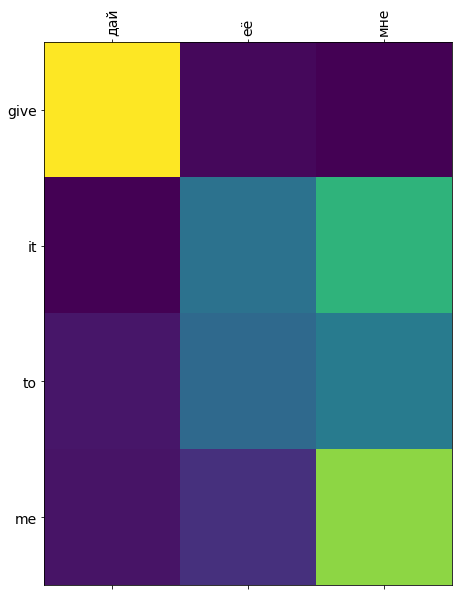

In [27]:
predict_input_string = validation.sample(1).values[0]
print('Input russian string: ',predict_input_string[0])
predicted,attention_plot = predictTask(predict_input_string[0],model)
print('Predicted Output string: ',predicted)
print('True Output string: ',predict_input_string[2])
attention_plot = attention_plot[:len(predicted.split()[:-1]), :len((predict_input_string[0]).split())]
attentionPlot(attention_plot,predicted,predict_input_string[0])

In [28]:
#Sample example
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
sample_test  = validation.sample(1000)
bleu_score = []
for datapoint in tqdm(sample_test.values):
    predicted,attention_plot = predictTask(datapoint[0],model)
    predicted = predicted.split()[:-1]
    actual = [datapoint[2].split()[:-1]]
    bleu_score.append(bleu.sentence_bleu(actual, predicted))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Dhananjay\AppData\Local\Programs\Python\Python37\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Dhananjay\AppData\Local\Programs\Python\Python37\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Dhananjay\AppData\Local\Programs\Python\Python37\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis 

In [29]:
print("Average Bleu score for concat model is: ",np.mean(np.array(bleu_score)))     

Average Bleu score for concat model is:  0.5970476272110348
